In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider

interactive(children=(IntSlider(value=5, description='n', max=10, min=3), IntSlider(value=2, description='k', …

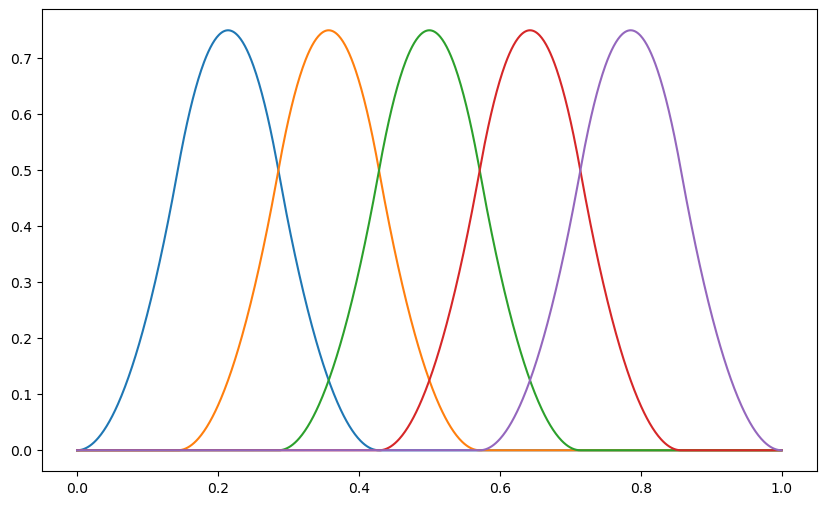

In [4]:
def bspline_basis(t, k, i, x):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    else:
        coeff1 = (x - t[i]) / (t[i+k] - t[i]) if t[i+k] != t[i] else 0
        coeff2 = (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) if t[i+k+1] != t[i+1] else 0
        return coeff1 * bspline_basis(t, k-1, i, x) + coeff2 * bspline_basis(t, k-1, i+1, x)

def plot_bspline_basis(n, k):
    t = np.linspace(0, 1, n+k+1)  # Generate knot vector
    x = np.linspace(0, 1, 1000)   # Points to evaluate the basis functions
    plt.figure(figsize=(10, 6))
    for i in range(n+k):
        y = [bspline_basis(t, k, i, xi) for xi in x]
        plt.plot(x, y, label=f'B_{i},{k}(x)')
    plt.title(f'B-spline Basis Functions of order {k}')
    plt.xlabel('x')
    plt.ylabel('B(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Interactive plot
iface = interactive(plot_bspline_basis, n=IntSlider(min=3, max=10, step=1, value=5), k=IntSlider(min=0, max=3, step=1, value=2))
iface